<a href="https://colab.research.google.com/github/SatoruGojo9/24f1002697_git_challenge_lab/blob/main/PROJECT_2_ANN_(Artificial_Neural_Networks)_Student_Performance_Prediction_using_ANN_(SHREESH_GURURAJ_KULKARNI_(25_AIML_A6_DEC_8336).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SECTION 1: IMPORT LIBRARIES AND SETUP

# Purpose: Import all necessary libraries for deep learning and data processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ Keras version: {keras.__version__}")
print("✓ All libraries imported successfully")

✓ TensorFlow version: 2.19.0
✓ Keras version: 3.10.0
✓ All libraries imported successfully


## SECTION 2: DATA LOADING AND INITIAL EXPLORATION

# Purpose: Load dataset and perform exploratory data analysis

In [2]:
df = pd.read_csv('/content/student-mat.csv', sep=';')
print("✓ Dataset loaded successfully from local path")

# Display basic information
print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset Shape: {df.shape}")
print(f"Number of students: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum().sum())

print("\nColumn Names:")
print(df.columns.tolist())

✓ Dataset loaded successfully from local path

DATASET INFORMATION
Dataset Shape: (395, 33)
Number of students: 395
Number of features: 33

First 5 rows:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2

# SECTION 3: DATA PREPROCESSING

# Purpose: Clean data, handle categorical variables, and prepare for modeling

In [3]:
print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Check for missing values
if df.isnull().sum().sum() > 0:
    print("Missing values detected:")
    print(df.isnull().sum())
    df = df.dropna()
    print("✓ Missing values removed")
else:
    print("✓ No missing values found")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ Removed {duplicates} duplicate rows")

# Define target variable (G3 is final grade)
target_column = 'G3'
print(f"\n✓ Target variable: {target_column} (Final Grade)")

# Separate features and target
X = df.drop(['G3'], axis=1)  # Remove final grade and potentially G1, G2 for harder prediction
y = df['G3']

# For more challenging prediction, we'll also remove G1 and G2
# (These are highly correlated with G3)
if 'G1' in X.columns and 'G2' in X.columns:
    print("✓ Removing G1 and G2 for more realistic prediction")
    X = X.drop(['G1', 'G2'], axis=1)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")


DATA PREPROCESSING
✓ No missing values found
Number of duplicate rows: 0

✓ Target variable: G3 (Final Grade)
✓ Removing G1 and G2 for more realistic prediction

Features shape: (395, 30)
Target shape: (395,)

Categorical columns (17): ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Numerical columns (13): ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


## SECTION 4: FEATURE ENCODING

# Purpose: Convert categorical variables to numerical format


In [4]:
print("\n" + "="*70)
print("FEATURE ENCODING")
print("="*70)

# Create a copy for encoding
X_encoded = X.copy()

# Label Encoding for binary categorical variables
binary_cols = []
for col in categorical_cols:
    if X[col].nunique() == 2:
        binary_cols.append(col)

print(f"Binary columns for Label Encoding: {binary_cols}")

label_encoders = {}
for col in binary_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le
    print(f"✓ Encoded '{col}': {list(le.classes_)}")

# One-Hot Encoding for multi-category variables
multi_category_cols = [col for col in categorical_cols if col not in binary_cols]
print(f"\nMulti-category columns for One-Hot Encoding: {multi_category_cols}")

if len(multi_category_cols) > 0:
    X_encoded = pd.get_dummies(X_encoded, columns=multi_category_cols, drop_first=True)
    print(f"✓ One-hot encoding completed")
    print(f"  Original features: {len(X.columns)}")
    print(f"  Encoded features: {len(X_encoded.columns)}")

print(f"\n✓ Total features after encoding: {X_encoded.shape[1]}")


FEATURE ENCODING
Binary columns for Label Encoding: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
✓ Encoded 'school': ['GP', 'MS']
✓ Encoded 'sex': ['F', 'M']
✓ Encoded 'address': ['R', 'U']
✓ Encoded 'famsize': ['GT3', 'LE3']
✓ Encoded 'Pstatus': ['A', 'T']
✓ Encoded 'schoolsup': ['no', 'yes']
✓ Encoded 'famsup': ['no', 'yes']
✓ Encoded 'paid': ['no', 'yes']
✓ Encoded 'activities': ['no', 'yes']
✓ Encoded 'nursery': ['no', 'yes']
✓ Encoded 'higher': ['no', 'yes']
✓ Encoded 'internet': ['no', 'yes']
✓ Encoded 'romantic': ['no', 'yes']

Multi-category columns for One-Hot Encoding: ['Mjob', 'Fjob', 'reason', 'guardian']
✓ One-hot encoding completed
  Original features: 30
  Encoded features: 39

✓ Total features after encoding: 39


## SECTION 5: FEATURE NORMALIZATION

# Purpose: Scale features to standard range for neural network training


FEATURE NORMALIZATION
✓ StandardScaler applied successfully

Feature statistics after normalization:
             school           sex           age       address       famsize  \
count  3.950000e+02  3.950000e+02  3.950000e+02  3.950000e+02  3.950000e+02   
mean  -3.597685e-17 -7.195369e-17  1.223213e-15 -1.618958e-16  6.295948e-17   
std    1.001268e+00  1.001268e+00  1.001268e+00  1.001268e+00  1.001268e+00   
min   -3.630498e-01 -9.481764e-01 -1.330954e+00 -1.867789e+00 -6.369411e-01   
25%   -3.630498e-01 -9.481764e-01 -5.462869e-01  5.353923e-01 -6.369411e-01   
50%   -3.630498e-01 -9.481764e-01  2.383798e-01  5.353923e-01 -6.369411e-01   
75%   -3.630498e-01  1.054656e+00  1.023046e+00  5.353923e-01  1.570004e+00   
max    2.754443e+00  1.054656e+00  4.161713e+00  5.353923e-01  1.570004e+00   

            Pstatus          Medu          Fedu    traveltime     studytime  \
count  3.950000e+02  3.950000e+02  3.950000e+02  3.950000e+02  3.950000e+02   
mean  -1.349132e-17  5.39652

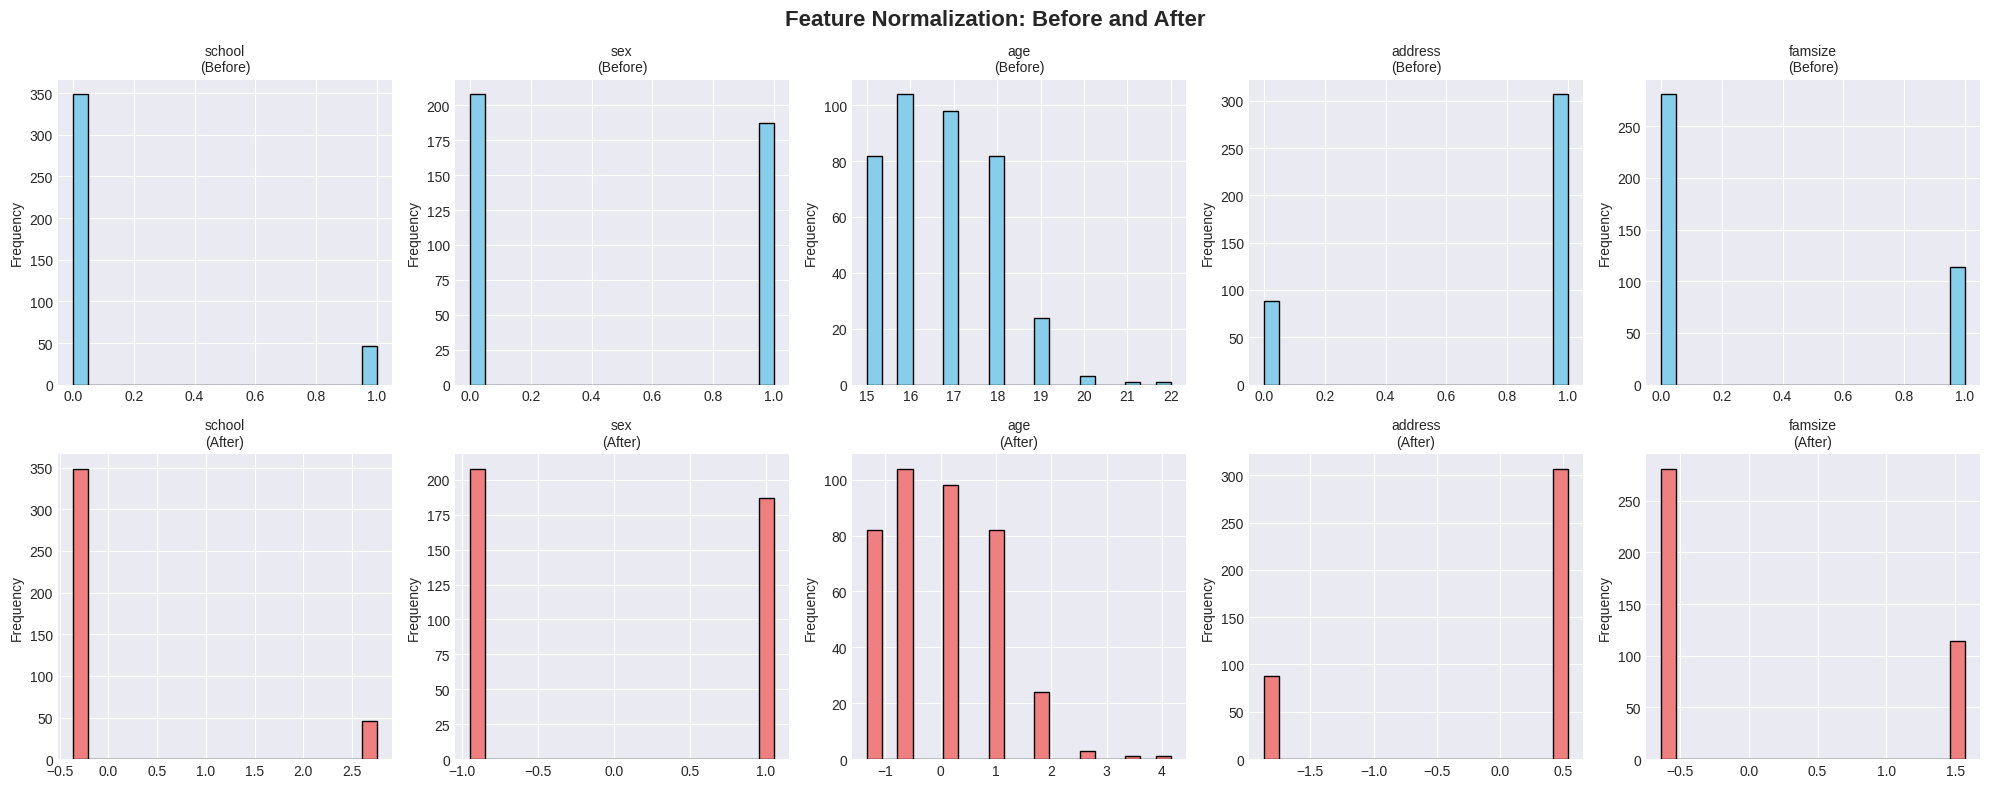


FEATURE NORMALIZATION
✓ StandardScaler applied successfully

Feature statistics after normalization:
             school           sex           age       address       famsize  \
count  3.950000e+02  3.950000e+02  3.950000e+02  3.950000e+02  3.950000e+02   
mean  -3.597685e-17 -7.195369e-17  1.223213e-15 -1.618958e-16  6.295948e-17   
std    1.001268e+00  1.001268e+00  1.001268e+00  1.001268e+00  1.001268e+00   
min   -3.630498e-01 -9.481764e-01 -1.330954e+00 -1.867789e+00 -6.369411e-01   
25%   -3.630498e-01 -9.481764e-01 -5.462869e-01  5.353923e-01 -6.369411e-01   
50%   -3.630498e-01 -9.481764e-01  2.383798e-01  5.353923e-01 -6.369411e-01   
75%   -3.630498e-01  1.054656e+00  1.023046e+00  5.353923e-01  1.570004e+00   
max    2.754443e+00  1.054656e+00  4.161713e+00  5.353923e-01  1.570004e+00   

            Pstatus          Medu          Fedu    traveltime     studytime  \
count  3.950000e+02  3.950000e+02  3.950000e+02  3.950000e+02  3.950000e+02   
mean  -1.349132e-17  5.39652

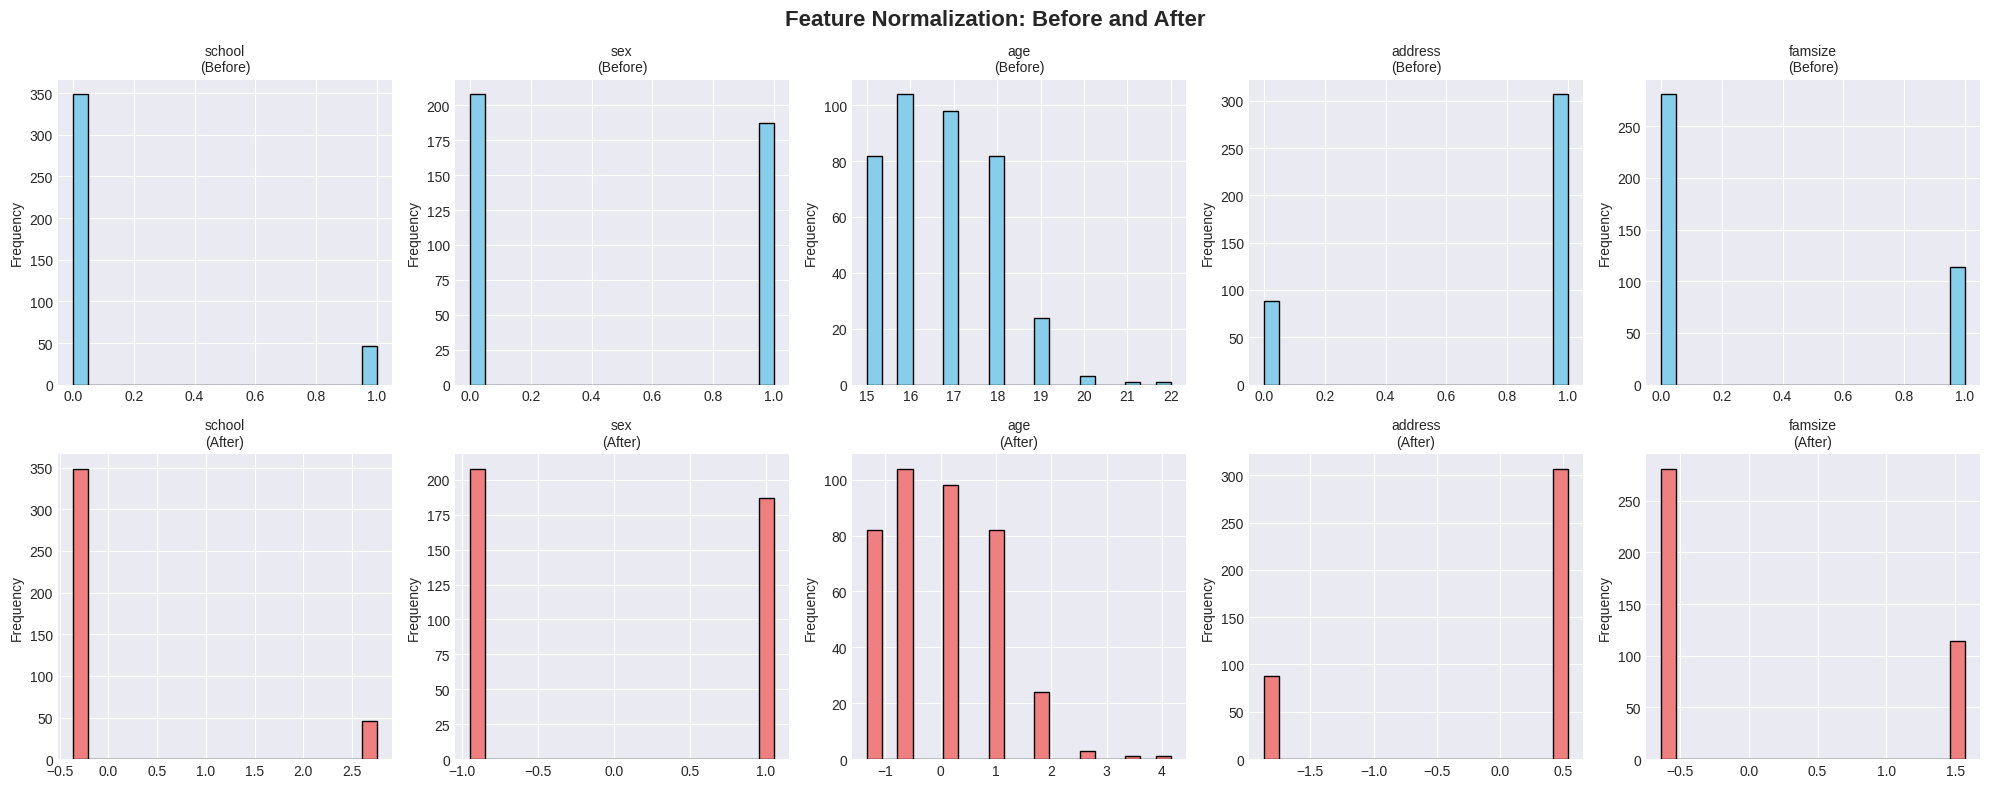

In [6]:
print("\n" + "="*70)
print("FEATURE NORMALIZATION")
print("="*70)

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)

print("✓ StandardScaler applied successfully")
print("\nFeature statistics after normalization:")
print(X_scaled_df.describe())

# Visualize normalization effect
sample_features = X_encoded.columns[:5]  # Show first 5 features
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Feature Normalization: Before and After', fontsize=16, fontweight='bold')

for idx, col in enumerate(sample_features):
    col_idx = X_encoded.columns.get_loc(col)

    # Before normalization
    axes[0, idx].hist(X_encoded[col], bins=20, color='skyblue', edgecolor='black')
    axes[0, idx].set_title(f'{col}\n(Before)', fontsize=10)
    axes[0, idx].set_ylabel('Frequency')

    # After normalization
    axes[1, idx].hist(X_scaled[:, col_idx], bins=20, color='lightcoral', edgecolor='black')
    axes[1, idx].set_title(f'{col}\n(After)', fontsize=10)
    axes[1, idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## SECTION 6: TARGET VARIABLE ANALYSIS

# Purpose: Analyze target variable distribution and prepare for modeling


TARGET VARIABLE ANALYSIS
Target variable (G3) statistics:
count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64


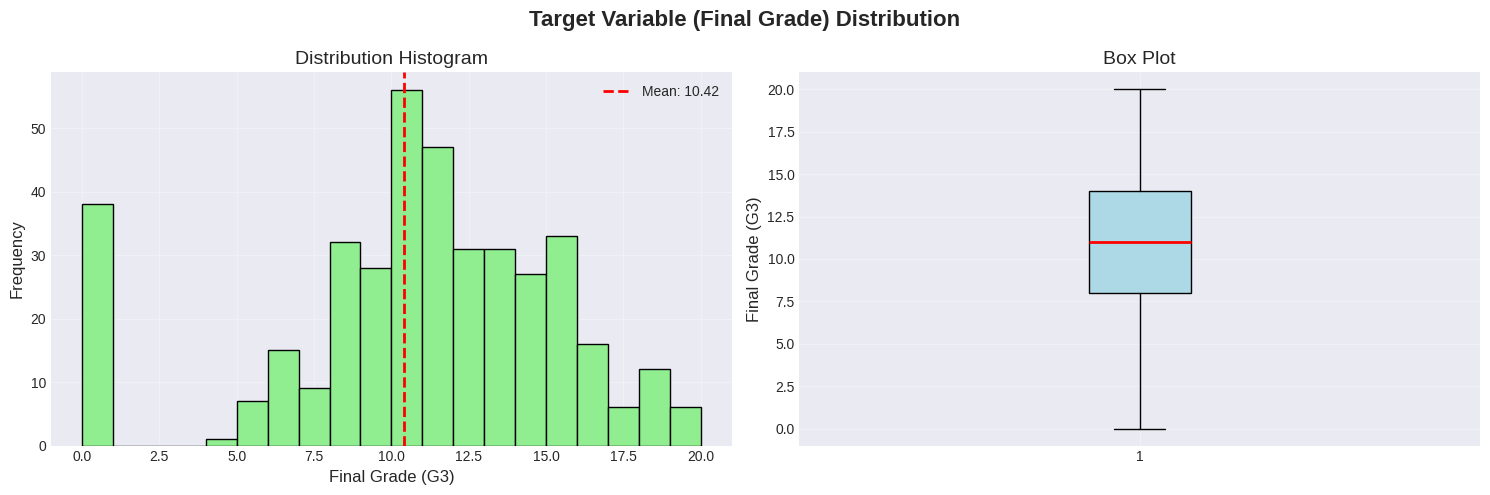


✓ Task Type: Regression (Continuous Grade Prediction)
  Grade Range: 0 - 20
  Mean Grade: 10.42
  Standard Deviation: 4.58


In [7]:
print("\n" + "="*70)
print("TARGET VARIABLE ANALYSIS")
print("="*70)

# Analyze target distribution
print("Target variable (G3) statistics:")
print(y.describe())

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Target Variable (Final Grade) Distribution', fontsize=16, fontweight='bold')

# Histogram
axes[0].hist(y, bins=20, color='lightgreen', edgecolor='black')
axes[0].set_xlabel('Final Grade (G3)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution Histogram', fontsize=14)
axes[0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y.mean():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(y, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Final Grade (G3)', fontsize=12)
axes[1].set_title('Box Plot', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Decide task type: Regression (predicting continuous grade)
print("\n✓ Task Type: Regression (Continuous Grade Prediction)")
print(f"  Grade Range: {y.min()} - {y.max()}")
print(f"  Mean Grade: {y.mean():.2f}")
print(f"  Standard Deviation: {y.std():.2f}")

## SECTION 7: TRAIN-TEST-VALIDATION SPLIT

# Purpose: Split data into training, validation, and test sets


In [8]:
print("\n" + "="*70)
print("TRAIN-VALIDATION-TEST SPLIT")
print("="*70)

# Split ratios: 70% train, 15% validation, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42  # 0.176 of 85% ≈ 15% of total
)

print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.1f} %)")
print(f"Validation set size: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_scaled)*100:.1f} %)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.1f} %)")
print(f"Number of features: {X_train.shape[1]}")

print("\n✓ Data split completed successfully")


TRAIN-VALIDATION-TEST SPLIT
Training set size: 276 samples (69.9 %)
Validation set size: 59 samples (14.9 %)
Test set size: 60 samples (15.2 %)
Number of features: 39

✓ Data split completed successfully


## SECTION 8: BUILD ANN MODEL ARCHITECTURE

# Purpose: Design and compile the Artificial Neural Network


In [9]:
print("\n" + "="*70)
print("ANN MODEL ARCHITECTURE")
print("="*70)

def create_ann_model(input_dim, neurons_layer1=64, neurons_layer2=32,
                     dropout_rate=0.3, activation='relu'):
    """
    Create a feedforward neural network (MLP)

    Parameters:
    - input_dim: Number of input features
    - neurons_layer1: Neurons in first hidden layer
    - neurons_layer2: Neurons in second hidden layer
    - dropout_rate: Dropout rate for regularization
    - activation: Activation function for hidden layers
    """
    model = Sequential([
        # Input Layer (implicit with first Dense layer)
        Dense(neurons_layer1, activation=activation, input_dim=input_dim,
              name='Hidden_Layer_1'),
        Dropout(dropout_rate, name='Dropout_1'),

        # Hidden Layer 2
        Dense(neurons_layer2, activation=activation, name='Hidden_Layer_2'),
        Dropout(dropout_rate, name='Dropout_2'),

        # Output Layer (1 neuron for regression)
        Dense(1, activation='linear', name='Output_Layer')
    ])

    return model

# Create the model
input_features = X_train.shape[1]
model = create_ann_model(input_dim=input_features,
                         neurons_layer1=64,
                         neurons_layer2=32,
                         dropout_rate=0.3,
                         activation='relu')

# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

print("✓ Model created and compiled successfully")
print("\nModel Architecture:")
print("="*70)
print(model.summary())


ANN MODEL ARCHITECTURE
✓ Model created and compiled successfully

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 64)             │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

None


## SECTION 9: VISUALIZE MODEL ARCHITECTURE

# Purpose: Create visual diagram of the neural network


MODEL ARCHITECTURE VISUALIZATION
✓ Model architecture diagram saved


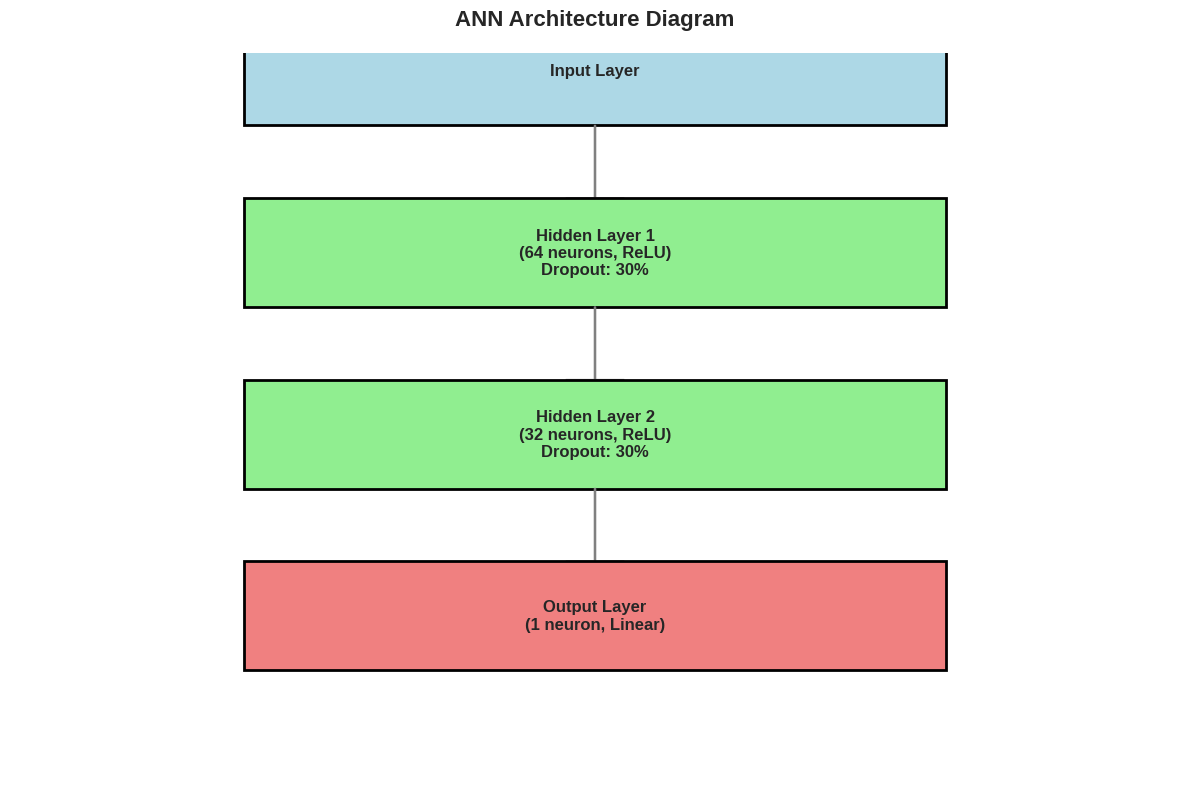

✓ Custom architecture visualization created


In [11]:
import os

print("\n" + "="*70)
print("MODEL ARCHITECTURE VISUALIZATION")
print("="*70)

# Ensure output directory exists
output_dir = '/mnt/user-data/outputs/'
os.makedirs(output_dir, exist_ok=True)

# Save architecture diagram
try:
    plot_model(model, to_file=os.path.join(output_dir, 'ann_architecture.png'),
               show_shapes=True, show_layer_names=True, rankdir='TB',
               dpi=150)
    print("✓ Model architecture diagram saved")
except Exception as e:
    print(f"! Could not generate architecture diagram (graphviz not available or other error: {e})")

# Create custom visualization
def visualize_ann_architecture():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    # Layer information
    layers = [
        ('Input Layer', input_features, 0.9),
        ('Hidden Layer 1\n(64 neurons, ReLU)\nDropout: 30%', 64, 0.65),
        ('Hidden Layer 2\n(32 neurons, ReLU)\nDropout: 30%', 32, 0.4),
        ('Output Layer\n(1 neuron, Linear)', 1, 0.15)
    ]

    for i, (name, neurons, y_pos) in enumerate(layers):
        # Draw layer box
        if i == 0:
            color = 'lightblue'
        elif i == len(layers) - 1:
            color = 'lightcoral'
        else:
            color = 'lightgreen'

        ax.add_patch(plt.Rectangle((0.2, y_pos), 0.6, 0.15,
                                   facecolor=color, edgecolor='black', linewidth=2))
        ax.text(0.5, y_pos + 0.075, name, ha='center', va='center',
               fontsize=12, fontweight='bold')

        # Draw connections
        if i < len(layers) - 1:
            ax.arrow(0.5, y_pos, 0, -(y_pos - layers[i+1][2]) + 0.15,
                    head_width=0.05, head_length=0.02, fc='gray', ec='gray')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('ANN Architecture Diagram', fontsize=16, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'ann_architecture_custom.png'), dpi=150, bbox_inches='tight')
    plt.show()

visualize_ann_architecture()
print("✓ Custom architecture visualization created")

## SECTION 10: TRAIN THE MODEL

# Purpose: Train the neural network with early stopping and checkpointing

In [12]:
print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/mnt/user-data/outputs/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

# Train the model
print("Training in progress...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("\n✓ Model training completed")
print(f"✓ Best model saved to: /mnt/user-data/outputs/best_model.keras")


MODEL TRAINING
Training in progress...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 126.9970 - mae: 10.4452 - mse: 126.9970 - val_loss: 108.5792 - val_mae: 9.2236 - val_mse: 108.5792
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 113.4761 - mae: 9.8520 - mse: 113.4761 - val_loss: 96.5585 - val_mae: 8.7566 - val_mse: 96.5585
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 102.1357 - mae: 9.3184 - mse: 102.1357 - val_loss: 84.4608 - val_mae: 8.2364 - val_mse: 84.4608
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 89.7609 - mae: 8.7260 - mse: 89.7609 - val_loss: 72.2307 - val_mae: 7.6407 - val_mse: 72.2307
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 73.3890 - mae: 7.8251 - mse: 73.3890 - val_loss: 59.9204 - val_mae: 6.9341 - val_mse: 59.9204
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 59.9902 - mae: 6.9370 - mse: 59.9902 - val_loss: 48.5898 - val_mae: 6.1946 - val_mse: 48.5898
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s

## SECTION 11: PLOT TRAINING CURVES

# Purpose: Visualize training and validation loss and accuracy curves



TRAINING HISTORY VISUALIZATION


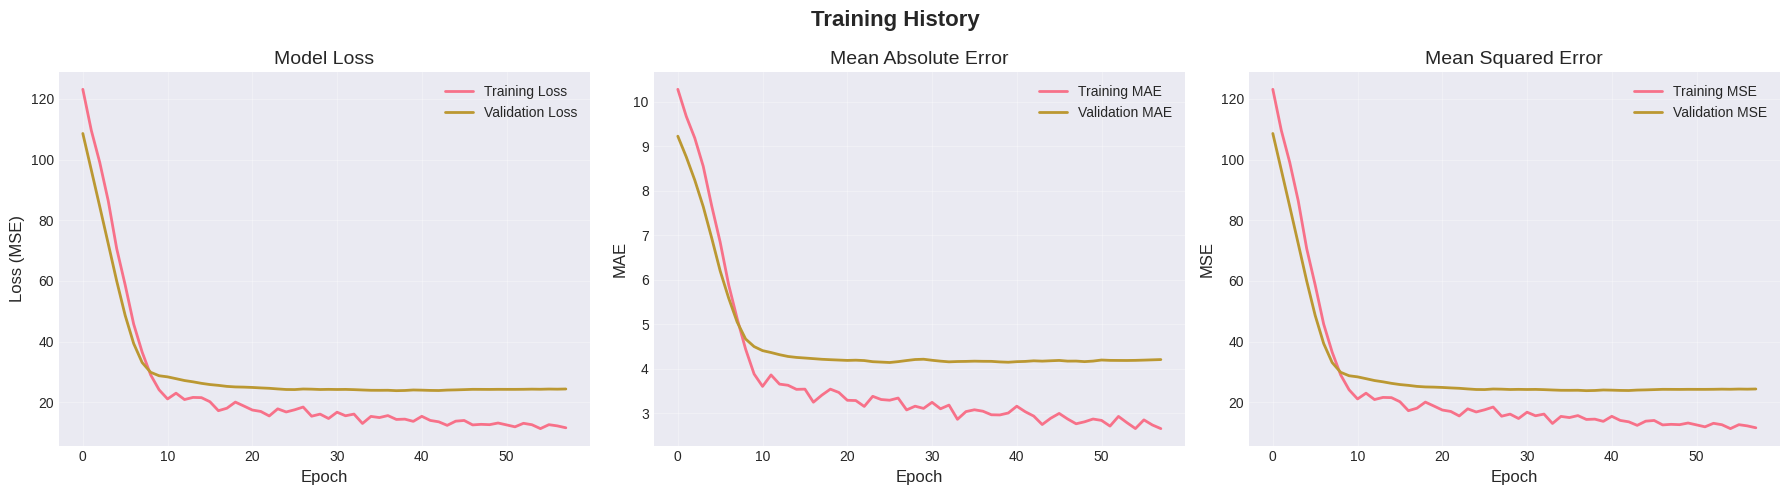

✓ Training curves saved


In [13]:
print("\n" + "="*70)
print("TRAINING HISTORY VISUALIZATION")
print("="*70)

# Plot loss curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Loss', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Mean Absolute Error', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MSE
axes[2].plot(history.history['mse'], label='Training MSE', linewidth=2)
axes[2].plot(history.history['val_mse'], label='Validation MSE', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('MSE', fontsize=12)
axes[2].set_title('Mean Squared Error', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training curves saved")

## SECTION 12: MODEL EVALUATION ON TEST SET

# Purpose: Evaluate model performance on unseen test data

In [14]:
print("\n" + "="*70)
print("MODEL EVALUATION ON TEST SET")
print("="*70)

# Make predictions
y_pred = model.predict(X_test, verbose=0)
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))
r2 = r2_score(y_test, y_pred)

print("Test Set Performance:")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  R² Score: {r2:.4f}")

# Accuracy within certain grade range
within_1_grade = np.sum(np.abs(y_test - y_pred) <= 1) / len(y_test) * 100
within_2_grades = np.sum(np.abs(y_test - y_pred) <= 2) / len(y_test) * 100

print(f"\n  Predictions within ±1 grade: {within_1_grade:.1f}%")
print(f"  Predictions within ±2 grades: {within_2_grades:.1f}%")


MODEL EVALUATION ON TEST SET
Test Set Performance:
  Mean Squared Error (MSE): 19.3330
  Root Mean Squared Error (RMSE): 4.3969
  Mean Absolute Error (MAE): 3.5924
  R² Score: 0.1257

  Predictions within ±1 grade: 13.3%
  Predictions within ±2 grades: 28.3%


## SECTION 13: PREDICTION VISUALIZATION

# Purpose: Visualize actual vs predicted values


PREDICTION VISUALIZATION


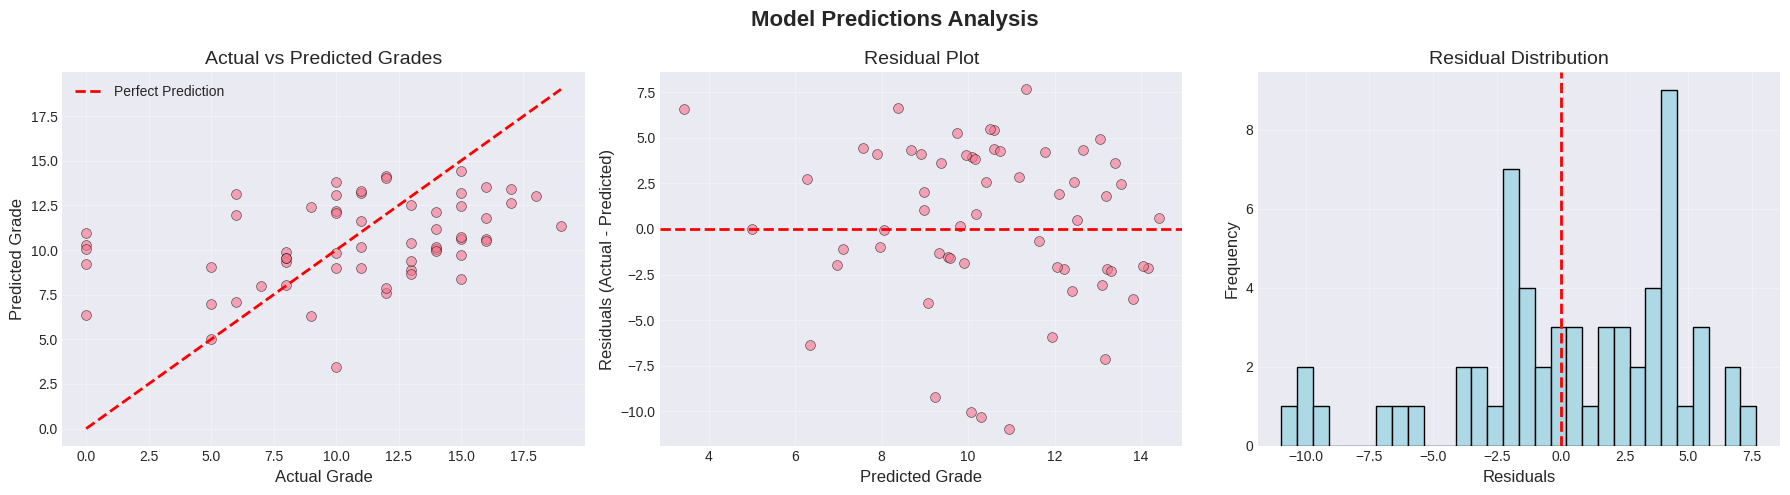

✓ Prediction visualizations saved


In [15]:
print("\n" + "="*70)
print("PREDICTION VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Predictions Analysis', fontsize=16, fontweight='bold')

# Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, y_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Grade', fontsize=12)
axes[0].set_ylabel('Predicted Grade', fontsize=12)
axes[0].set_title('Actual vs Predicted Grades', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Grade', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14)
axes[1].grid(True, alpha=0.3)

# Residual distribution
axes[2].hist(residuals, bins=30, color='lightblue', edgecolor='black')
axes[2].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[2].set_xlabel('Residuals', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Residual Distribution', fontsize=14)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/prediction_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Prediction visualizations saved")

## SECTION 14: CONFUSION MATRIX (FOR CLASSIFICATION VIEW)

# Purpose: Create confusion matrix by binning grades into categories


GRADE CLASSIFICATION ANALYSIS


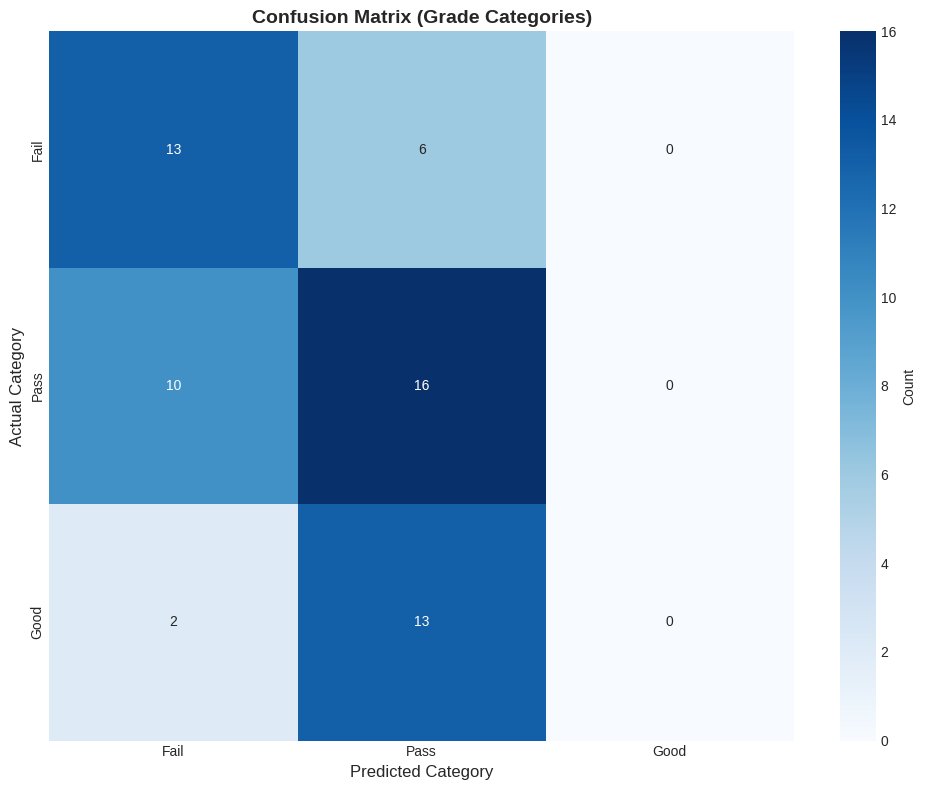


Classification Report:
              precision    recall  f1-score   support

        Fail       0.52      0.68      0.59        19
        Pass       0.00      0.00      0.00        15
        Good       0.46      0.62      0.52        26

    accuracy                           0.48        60
   macro avg       0.33      0.43      0.37        60
weighted avg       0.36      0.48      0.41        60



In [17]:
print("\n" + "="*70)
print("GRADE CLASSIFICATION ANALYSIS")
print("="*70)

# Bin grades into categories: Fail (0-9), Pass (10-14), Good (15-20)
def grade_to_category(grade):
    if grade < 10:
        return 'Fail'
    elif grade < 15:
        return 'Pass'
    else:
        return 'Good'

y_test_cat = [grade_to_category(g) for g in y_test]
y_pred_cat = [grade_to_category(g) for g in y_pred]

# Create confusion matrix
cm = confusion_matrix(y_test_cat, y_pred_cat, labels=['Fail', 'Pass', 'Good'])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fail', 'Pass', 'Good'],
            yticklabels=['Fail', 'Pass', 'Good'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('Actual Category', fontsize=12)
plt.title('Confusion Matrix (Grade Categories)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_cat, y_pred_cat, target_names=['Fail', 'Pass', 'Good']))

## SECTION 15: EXPERIMENT WITH DIFFERENT ARCHITECTURES

# Purpose: Test different hyperparameters and compare performance



HYPERPARAMETER EXPERIMENTATION
Testing different configurations...

  Configuration 1: {'neurons_l1': 32, 'neurons_l2': 16, 'dropout': 0.2, 'activation': 'relu'}
    MSE: 20.8939, MAE: 3.5825, R²: 0.0551

  Configuration 2: {'neurons_l1': 64, 'neurons_l2': 32, 'dropout': 0.3, 'activation': 'relu'}


    MSE: 18.6543, MAE: 3.4317, R²: 0.1564

  Configuration 3: {'neurons_l1': 128, 'neurons_l2': 64, 'dropout': 0.3, 'activation': 'relu'}
    MSE: 19.8280, MAE: 3.5949, R²: 0.1033

  Configuration 4: {'neurons_l1': 64, 'neurons_l2': 32, 'dropout': 0.3, 'activation': 'tanh'}
    MSE: 21.4889, MAE: 3.7000, R²: 0.0282

CONFIGURATION COMPARISON
                           Config       MSE      MAE       R²
 L1:32, L2:16, Drop:0.2, Act:relu 20.893944 3.582471 0.055095
 L1:64, L2:32, Drop:0.3, Act:relu 18.654280 3.431741 0.156382
L1:128, L2:64, Drop:0.3, Act:relu 19.828047 3.594921 0.103299
 L1:64, L2:32, Drop:0.3, Act:tanh 21.488895 3.699959 0.028189


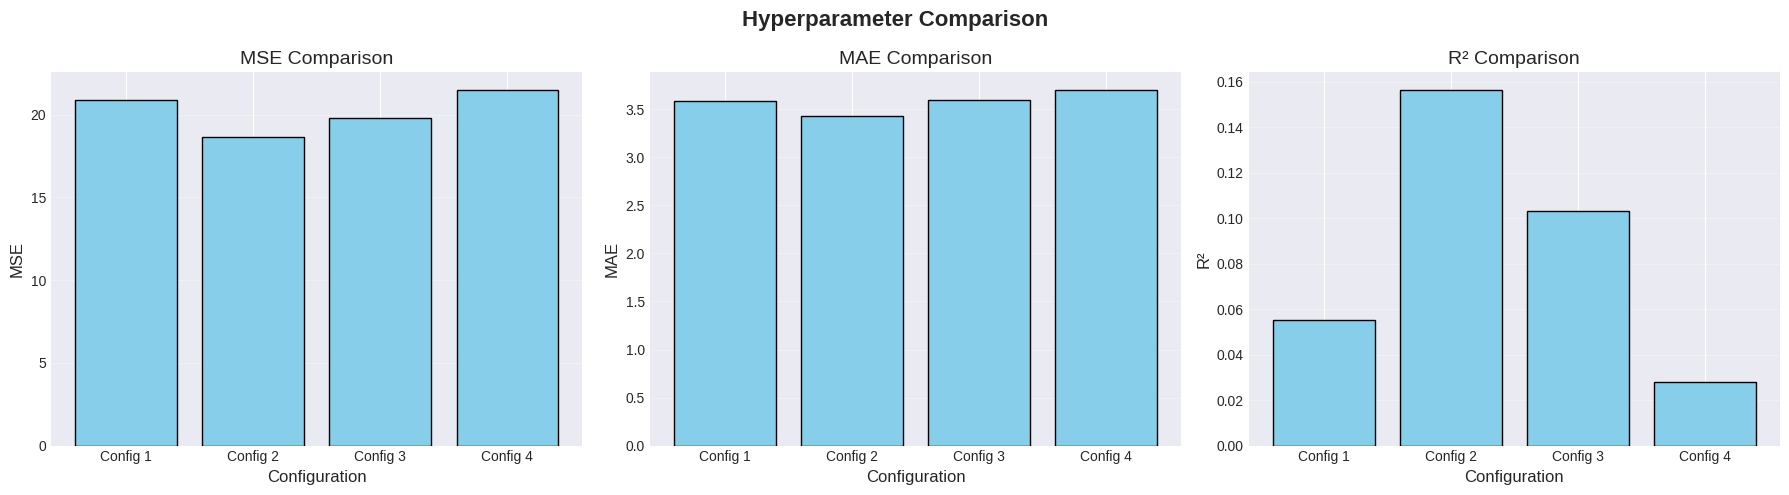

In [18]:
print("\n" + "="*70)
print("HYPERPARAMETER EXPERIMENTATION")
print("="*70)

# Test different configurations
configs = [
    {'neurons_l1': 32, 'neurons_l2': 16, 'dropout': 0.2, 'activation': 'relu'},
    {'neurons_l1': 64, 'neurons_l2': 32, 'dropout': 0.3, 'activation': 'relu'},
    {'neurons_l1': 128, 'neurons_l2': 64, 'dropout': 0.3, 'activation': 'relu'},
    {'neurons_l1': 64, 'neurons_l2': 32, 'dropout': 0.3, 'activation': 'tanh'},
]

results = []

print("Testing different configurations...")
for i, config in enumerate(configs):
    print(f"\n  Configuration {i+1}: {config}")

    # Create and train model
    test_model = create_ann_model(
        input_dim=input_features,
        neurons_layer1=config['neurons_l1'],
        neurons_layer2=config['neurons_l2'],
        dropout_rate=config['dropout'],
        activation=config['activation']
    )

    test_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    test_history = test_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate
    test_pred = test_model.predict(X_test, verbose=0).flatten()
    test_mse = mean_squared_error(y_test, test_pred)
    test_mae = np.mean(np.abs(y_test - test_pred))
    test_r2 = r2_score(y_test, test_pred)

    results.append({
        'Config': f"L1:{config['neurons_l1']}, L2:{config['neurons_l2']}, "
                 f"Drop:{config['dropout']}, Act:{config['activation']}",
        'MSE': test_mse,
        'MAE': test_mae,
        'R²': test_r2
    })

    print(f"    MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

# Display results
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("CONFIGURATION COMPARISON")
print("="*70)
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Hyperparameter Comparison', fontsize=16, fontweight='bold')

metrics = ['MSE', 'MAE', 'R²']
for idx, metric in enumerate(metrics):
    axes[idx].bar(range(len(results)), results_df[metric], color='skyblue', edgecolor='black')
    axes[idx].set_xlabel('Configuration', fontsize=12)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} Comparison', fontsize=14)
    axes[idx].set_xticks(range(len(results)))
    axes[idx].set_xticklabels([f'Config {i+1}' for i in range(len(results))])
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/hyperparameter_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## SECTION 16: SAVE RESULTS AND MODEL

# Purpose: Export all results and trained model

In [20]:
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save predictions
predictions_df = pd.DataFrame({
    'Actual_Grade': y_test.values,
    'Predicted_Grade': y_pred,
    'Absolute_Error': np.abs(y_test.values - y_pred),
    'Actual_Category': y_test_cat,
    'Predicted_Category': y_pred_cat
})
predictions_df.to_csv('/mnt/user-data/outputs/student_predictions.csv', index=False)
print("✓ Predictions saved")

# Save model summary
with open('/mnt/user-data/outputs/model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("✓ Model summary saved")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('/mnt/user-data/outputs/training_history.csv', index=False)
print("✓ Training history saved")

# Save configuration comparison
results_df.to_csv('/mnt/user-data/outputs/hyperparameter_results.csv', index=False)
print("✓ Hyperparameter results saved")


# ============================================================================
# SECTION 17: PROJECT SUMMARY
# ============================================================================
# Purpose: Provide comprehensive summary of the project

print("\n" + "="*70)
print("PROJECT 2 COMPLETED SUCCESSFULLY! ✓")
print("="*70)

summary = f"""

STUDENT PERFORMANCE PREDICTION - PROJECT SUMMARY
================================================

MODEL ARCHITECTURE:
- Type: Feedforward Neural Network (MLP)
- Input Features: {input_features}
- Hidden Layer 1: 64 neurons (ReLU) + Dropout (30%)
- Hidden Layer 2: 32 neurons (ReLU) + Dropout (30%)
- Output Layer: 1 neuron (Linear)
- Optimizer: Adam
- Loss Function: Mean Squared Error

TRAINING DETAILS:
- Training Samples: {len(X_train)}
- Validation Samples: {len(X_val)}
- Test Samples: {len(X_test)}
- Epochs Trained: {len(history.history['loss'])}
- Batch Size: 32

PERFORMANCE METRICS (Test Set):
- Mean Squared Error: {mse:.4f}
- Root Mean Squared Error: {rmse:.4f}
- Mean Absolute Error: {mae:.4f}
- R² Score: {r2:.4f}
- Predictions within ±1 grade: {within_1_grade:.1f}%
- Predictions within ±2 grades: {within_2_grades:.1f}%

DELIVERABLES GENERATED:
1. ✓ Model architecture diagram
2. ✓ Training curves (loss, MAE, MSE)
3. ✓ Prediction visualizations
4. ✓ Confusion matrix
5. ✓ Hyperparameter comparison
6. ✓ Saved model and predictions

KEY LEARNING OUTCOMES ACHIEVED:
• ANN architecture design
• Backpropagation and gradient descent
• Overfitting prevention with dropout
• Regularization techniques
• Model evaluation and comparison

NEXT STEPS:
- Fine-tune hyperparameters for better performance
- Include G1 and G2 grades for easier prediction
- Try different activation functions
- Experiment with more hidden layers
- Consider ensemble methods

================================================
Report Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
================================================
"""

print(summary)

# Save summary
with open('/mnt/user-data/outputs/project_summary.txt', 'w') as f:
    f.write(summary)

print("\n✓ Project summary saved")
print("="*70)


SAVING RESULTS
✓ Predictions saved


✓ Model summary saved
✓ Training history saved
✓ Hyperparameter results saved

PROJECT 2 COMPLETED SUCCESSFULLY! ✓


STUDENT PERFORMANCE PREDICTION - PROJECT SUMMARY

MODEL ARCHITECTURE:
- Type: Feedforward Neural Network (MLP)
- Input Features: 39
- Hidden Layer 1: 64 neurons (ReLU) + Dropout (30%)
- Hidden Layer 2: 32 neurons (ReLU) + Dropout (30%)
- Output Layer: 1 neuron (Linear)
- Optimizer: Adam
- Loss Function: Mean Squared Error

TRAINING DETAILS:
- Training Samples: 276
- Validation Samples: 59
- Test Samples: 60
- Epochs Trained: 58
- Batch Size: 32

PERFORMANCE METRICS (Test Set):
- Mean Squared Error: 19.3330
- Root Mean Squared Error: 4.3969
- Mean Absolute Error: 3.5924
- R² Score: 0.1257
- Predictions within ±1 grade: 13.3%
- Predictions within ±2 grades: 28.3%

DELIVERABLES GENERATED:
1. ✓ Model architecture diagram
2. ✓ Training curves (loss, MAE, MSE)
3. ✓ Prediction visualizations
4. ✓ Confusion matrix
5. ✓ Hyperparameter comparison
6. ✓ Saved model and predictions

